In [1]:
# import libraries for eda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import sys
import statsmodels.api as sm

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from time import strptime
from datetime import datetime

data_folderpath = r"data\!Spring_Invitational_2024_data\Datathon_Data" 

In [2]:
def str_to_numeric(s, check_numeric=True, comma_is_dot=False):
    if not isinstance(s, str):
        return s
    s_clean = s.replace("%", "").replace("±", "").replace("(", "").replace(")", "").replace("R", "").replace("P", "")
    
    comma_replace = "." if comma_is_dot else ""
    s_clean = s_clean.replace(",", comma_replace)
    
    if s_clean.isnumeric() or not check_numeric:
        return float(s_clean)
    return s_clean

In [3]:
top_oil_producers = ["Texas", "New Mexico", "Oklahoma", "Colorado", "North Dakota", "Alaska"] # https://www.investopedia.com/financial-edge/0511/top-6-oil-producing-states.aspx

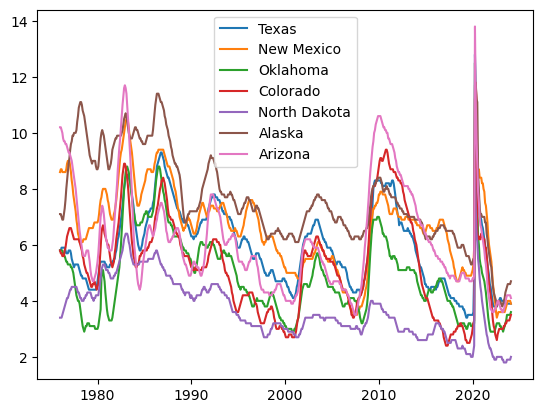

In [4]:
# Source: Bureau of Labor Statistics https://www.bls.gov/

dfs = []
for state in (top_oil_producers + ["Arizona"]):
    df = pd.read_csv(f"data\\employment_data\\{state.lower()}_unemployment.csv")
    df["unemployment rate"] = df["unemployment rate"].apply(lambda s: str_to_numeric(s, False))
    df["Month"] = df["Period"].apply(lambda s: strptime(s, "%b").tm_mon).astype(int)
    df["Quarter"] = ((df["Month"]-1) // 3 + 1).astype(int)
    df["Quarter_Date_Time"] = df.apply(lambda row: datetime(year=row["Year"], month=row["Quarter"]*3 - 2, day=1), axis=1)
    df["datetime"] = df.apply(lambda row: datetime(int(row["Year"]), int(row["Month"]), 1), axis=1)
    df["state"] = state
    dfs.append(df)
    
    plt.plot(df["datetime"], df["unemployment rate"], label=state)
    
unemployment_data = pd.concat(dfs)
    
plt.legend()
plt.show()

In [119]:
oil_and_gas_empl_texas = pd.read_csv("data\\employment_data\\texas_oil_and_gas_extraction.csv")
service_empl_texas = pd.read_csv("data\\employment_data\\texas_service_employees.csv")
labor_force_texas = pd.read_csv("data\\employment_data\\texas_labor_force.csv")

oil_and_gas_empl_texas = oil_and_gas_empl_texas[oil_and_gas_empl_texas["og_employees"] != "."]
service_empl_texas = service_empl_texas[service_empl_texas["service_employees"] != "."]

oil_and_gas_empl_texas["og_employees"] = oil_and_gas_empl_texas["og_employees"].apply(str_to_numeric).astype(float)
service_empl_texas["service_employees"] = service_empl_texas["service_employees"].apply(str_to_numeric).astype(float)

merged_empl_texas = oil_and_gas_empl_texas.merge(service_empl_texas, on="DATE")
merged_empl_texas["ratio"] = merged_empl_texas["og_employees"] / merged_empl_texas["service_employees"]
merged_empl_texas["ratio_diff"] = merged_empl_texas["ratio"].diff()
merged_empl_texas["Quarter_Date_Time"] = merged_empl_texas["DATE"].apply(lambda s: datetime.strptime(s, "%Y-%m-%d"))
merged_empl_texas["Year"] = merged_empl_texas["Quarter_Date_Time"].apply(lambda d: d.year)

merged_empl_texas = merged_empl_texas.dropna()

In [120]:
merged_empl_texas

,DATE,og_employees,service_employees,ratio,ratio_diff,Quarter_Date_Time,Year
1,1990-04-01,160.196005,5665.833333,0.028274,0.000232,1990-04-01,1990
2,1990-07-01,162.992481,5697.800000,0.028606,0.000332,1990-07-01,1990
3,1990-10-01,166.459221,5720.700000,0.029098,0.000491,1990-10-01,1990
4,1991-01-01,170.351373,5714.100000,0.029812,0.000715,1991-01-01,1991
5,1991-04-01,170.846537,5739.633333,0.029766,-0.000046,1991-04-01,1991
...,...,...,...,...,...,...,...
131,2022-10-01,207.281395,11729.533333,0.017672,0.000273,2022-10-01,2022
132,2023-01-01,212.285292,11838.966667,0.017931,0.000259,2023-01-01,2023
133,2023-04-01,212.482015,11896.866667,0.017860,-0.000071,2023-04-01,2023
134,2023-07-01,212.103653,11935.966667,0.017770,-0.000090,2023-07-01,2023


In [121]:
labor_force_texas["labor force"] = labor_force_texas["labor force"].apply(lambda s: str_to_numeric(s))
labor_force_texas["date_time"] = labor_force_texas.apply(lambda row: datetime(year=int(row["Year"]), month=datetime.strptime(row["Period"], "%b").month, day=1), axis=1)
labor_force_texas["Quarter"] = labor_force_texas["date_time"].apply(lambda s: (s.month-1) // 3 + 1).astype(int)
labor_force_texas["Quarter_Date_Time"] = labor_force_texas.apply(lambda row: datetime(year=int(row["Year"]), month=row["Quarter"]*3 - 2, day=1), axis=1)

labor_force_q_avg = labor_force_texas.groupby(["Quarter_Date_Time"]).agg({"labor force": "mean"}).reset_index()
labor_force_q_avg["labor_force_pct_change"] = labor_force_q_avg["labor force"].pct_change()
labor_force_q_avg = labor_force_q_avg.dropna()

Text(0.5, 1.0, 'Texas Labor Force')

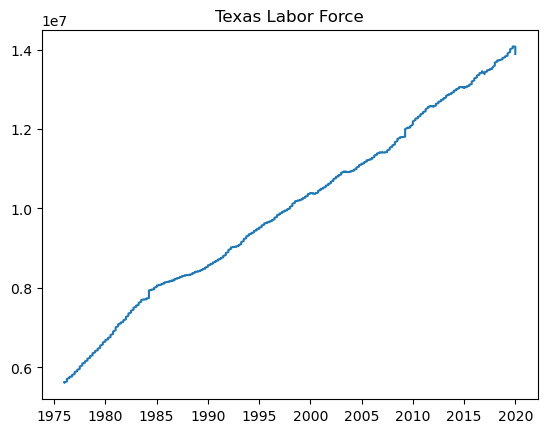

In [168]:
plt.plot(labor_force_texas[labor_force_texas["Quarter_Date_Time"] <= "2020"]["Quarter_Date_Time"], labor_force_texas[labor_force_texas["Quarter_Date_Time"] <= "2020"]["labor force"])
plt.title("Texas Labor Force")

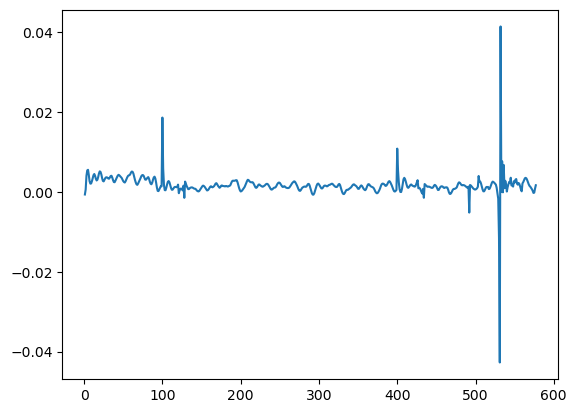

In [122]:
plt.plot(labor_force_texas["labor force"].pct_change().dropna())

In [123]:
adfuller(labor_force_texas["labor force"]), adfuller(labor_force_texas["labor force"].pct_change().dropna())

((-0.04643027944676282,
  0.9545197159516143,
  1,
  576,
  {'1%': -3.441753961421302,
   '5%': -2.866570853087291,
   '10%': -2.5694492998890817},
  13329.290363512864),
 (-2.946418567807246,
  0.04021032006586472,
  19,
  557,
  {'1%': -3.4421447800270673,
   '5%': -2.8667429272780858,
   '10%': -2.5695409929766093},
  -4913.131939100668))

In [124]:
adfuller(merged_empl_texas["ratio"]), adfuller(merged_empl_texas["ratio_diff"])

((-2.180533486222206,
  0.2133863825165837,
  4,
  130,
  {'1%': -3.4816817173418295,
   '5%': -2.8840418343195267,
   '10%': -2.578770059171598},
  -1526.2403028777876),
 (-4.822026253393888,
  4.934792612213165e-05,
  3,
  131,
  {'1%': -3.481281802271349,
   '5%': -2.883867891664528,
   '10%': -2.5786771965503177},
  -1524.0820107507798))

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

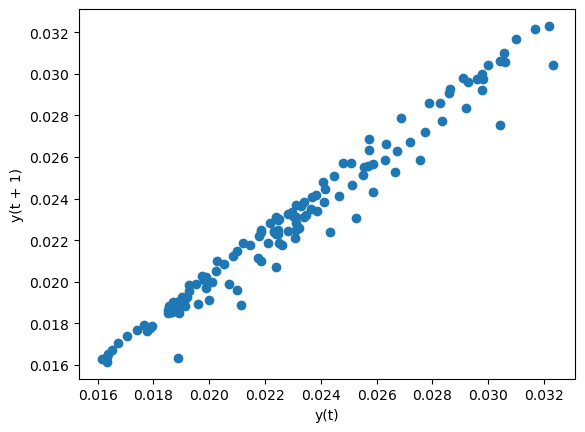

In [125]:
from pandas.plotting import lag_plot 

lag_plot(merged_empl_texas["ratio"])

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

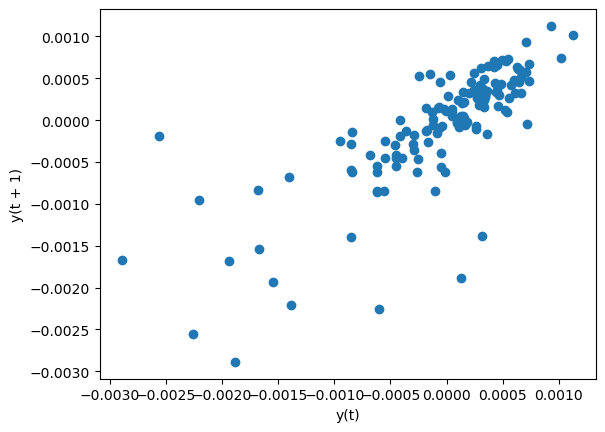

In [126]:
lag_plot(merged_empl_texas["ratio_diff"])

In [127]:
avg_quarterly_unemployment = unemployment_data.groupby(["Quarter_Date_Time", "state"]).agg({"unemployment rate": "mean"}).reset_index()

In [128]:
avg_q_une_texas = avg_quarterly_unemployment[avg_quarterly_unemployment["state"] == "Texas"]
avg_q_une_texas["ur_diff"] =  avg_q_une_texas["unemployment rate"].diff()
avg_q_une_texas["ur_lag_1"] =  avg_q_une_texas["unemployment rate"].shift(1)
avg_q_une_texas["ur_lag_2"] = avg_q_une_texas["unemployment rate"].shift(2)
avg_q_une_texas["ur_lag_3"] = avg_q_une_texas["unemployment rate"].shift(3)

C:\Users\botta\AppData\Local\Temp\ipykernel_15860\366127393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_q_une_texas["ur_diff"] =  avg_q_une_texas["unemployment rate"].diff()
C:\Users\botta\AppData\Local\Temp\ipykernel_15860\366127393.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_q_une_texas["ur_lag_1"] =  avg_q_une_texas["unemployment rate"].shift(1)
C:\Users\botta\AppData\Local\Temp\ipykernel_15860\366127393.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [129]:
avg_q_une_texas

,Quarter_Date_Time,state,unemployment rate,ur_diff,ur_lag_1,ur_lag_2,ur_lag_3
6,1976-01-01,Texas,5.833333,NaN,NaN,NaN,NaN
13,1976-04-01,Texas,5.900000,0.066667,5.833333,NaN,NaN
20,1976-07-01,Texas,5.800000,-0.100000,5.900000,5.833333,NaN
27,1976-10-01,Texas,5.733333,-0.066667,5.800000,5.900000,5.833333
34,1977-01-01,Texas,5.766667,0.033333,5.733333,5.800000,5.900000
...,...,...,...,...,...,...,...
1322,2023-01-01,Texas,4.033333,0.000000,4.033333,3.833333,3.800000
1329,2023-04-01,Texas,3.966667,-0.066667,4.033333,4.033333,3.833333
1336,2023-07-01,Texas,3.900000,-0.066667,3.966667,4.033333,4.033333
1343,2023-10-01,Texas,3.900000,0.000000,3.900000,3.966667,4.033333


In [130]:
adfuller(avg_q_une_texas["unemployment rate"])

(-3.103000353530763,
 0.026331944208480198,
 0,
 192,
 {'1%': -3.4648754262570978,
  '5%': -2.876714157488788,
  '10%': -2.574858699001736},
 364.5772133178841)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

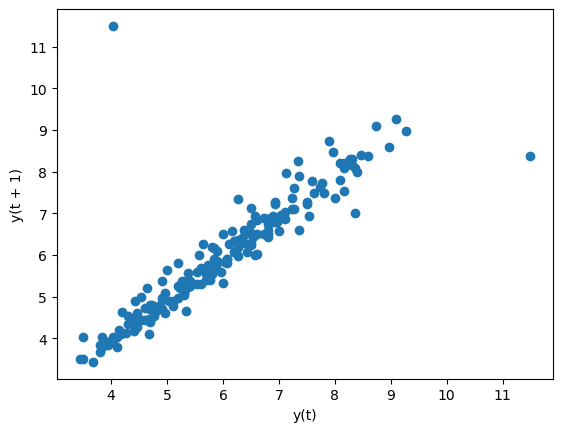

In [131]:
from pandas.plotting import lag_plot 

lag_plot(avg_q_une_texas["unemployment rate"])

In [132]:
# import data

commodities_data_path = data_folderpath + r"/all_commodities.csv"

print(commodities_data_path)

commodities_data = pd.read_csv(commodities_data_path).sort_values("Date_Time")

data\!Spring_Invitational_2024_data\Datathon_Data/all_commodities.csv


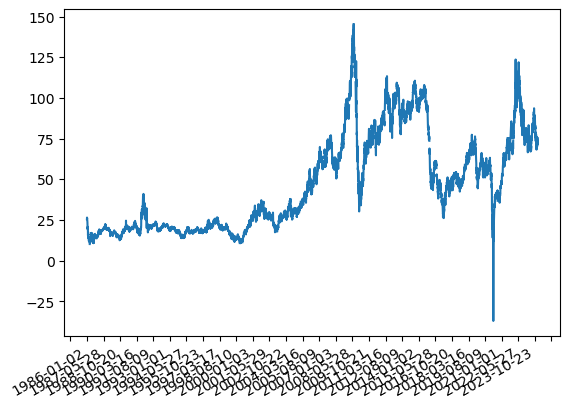

In [133]:
oil_price = commodities_data[commodities_data["Commodity_Simple"] == "WTI"]

plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.plot(oil_price["Date_Time"], oil_price["Value"])
plt.gcf().autofmt_xdate()
plt.show()

In [134]:
oil_price["Year"] = oil_price["Date_Time"].apply(lambda s: int(s[:4])).astype(int)
oil_price["Month"] = oil_price["Date_Time"].apply(lambda s: int(s[5:7]))
oil_price["Quarter"] = ((oil_price["Month"]-1) // 3 + 1).astype(int)
oil_price["Quarter_Date_Time"] = oil_price.apply(lambda row: datetime(year=row["Year"], month=row["Quarter"]*3 - 2, day=1), axis=1)
oil_price["log_price"] = np.log(oil_price["Value"])
oil_price["oil_price_realized_volatility"] = (oil_price["log_price"].diff())**2
realized_volatility = oil_price.groupby(["Quarter_Date_Time"]).agg({"oil_price_realized_volatility": "sum"}).reset_index()

C:\Users\botta\AppData\Local\Temp\ipykernel_15860\1920082863.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_price["Year"] = oil_price["Date_Time"].apply(lambda s: int(s[:4])).astype(int)
C:\Users\botta\AppData\Local\Temp\ipykernel_15860\1920082863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_price["Month"] = oil_price["Date_Time"].apply(lambda s: int(s[5:7]))
C:\Users\botta\AppData\Local\Temp\ipykernel_15860\1920082863.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy 

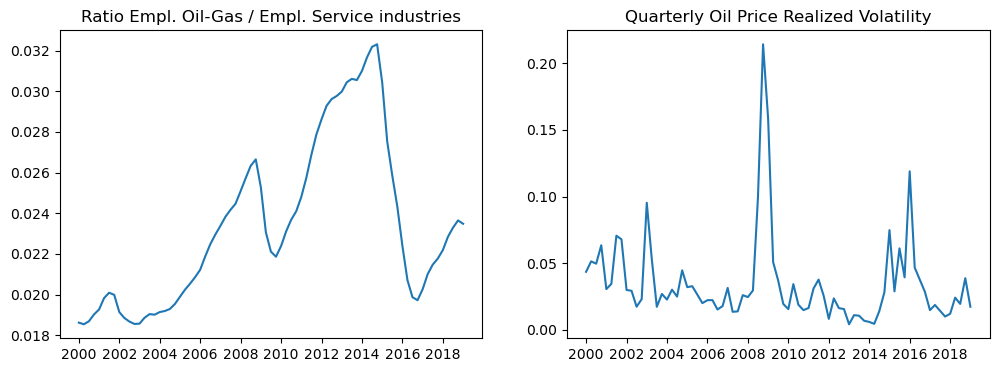

In [148]:
plot_rv = realized_volatility[(realized_volatility["Quarter_Date_Time"] >= "2000") & (realized_volatility["Quarter_Date_Time"] <= "2019")]
plot_ratio = merged_empl_texas[(merged_empl_texas["Quarter_Date_Time"] >= "2000") & (merged_empl_texas["Quarter_Date_Time"] <= "2019")]

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(plot_ratio["Quarter_Date_Time"], plot_ratio["ratio"])
ax[1].plot(plot_rv["Quarter_Date_Time"], plot_rv["oil_price_realized_volatility"])

ax[0].set_title("Ratio Empl. Oil-Gas / Empl. Service industries")
ax[1].set_title("Quarterly Oil Price Realized Volatility")
plt.show()

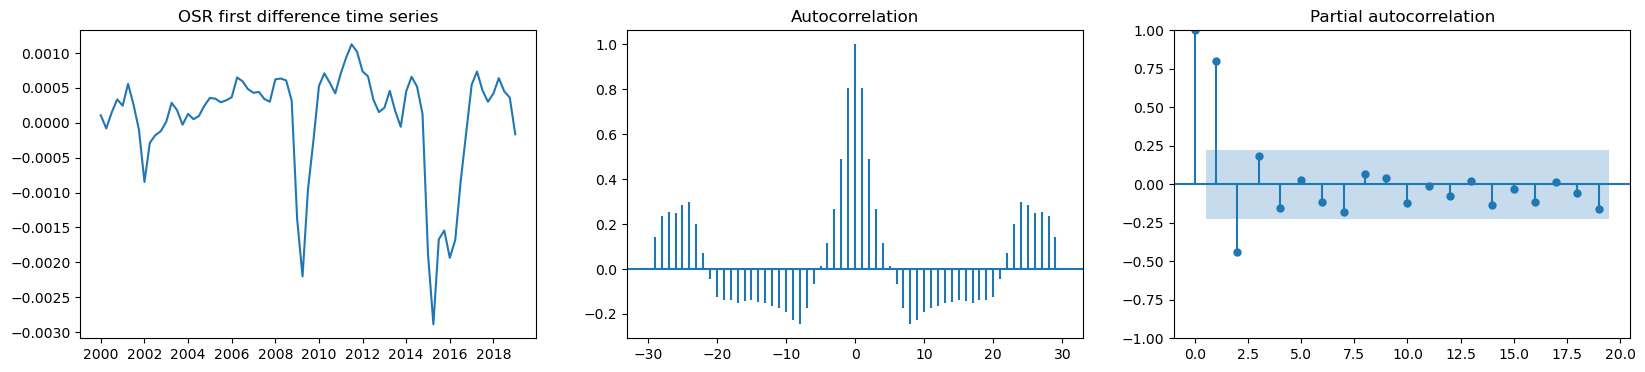

In [164]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(1, 3, figsize=(20,4))
ax[0].plot(plot_ratio["Quarter_Date_Time"], plot_ratio["ratio_diff"])
#ax[1].plot(plot_rv["Quarter_Date_Time"], plot_rv["oil_price_realized_volatility"])
ax[1].acorr(plot_ratio["ratio_diff"], maxlags = 30) 

plot_pacf(plot_ratio["ratio_diff"], ax=ax[2])
ax[0].set_title("OSR first difference time series")
ax[1].set_title("Autocorrelation")
ax[2].set_title("Partial autocorrelation")
plt.show()

In [25]:
adfuller(realized_volatility["oil_price_realized_volatility"])

(-6.065342556978947,
 1.18548666893912e-07,
 3,
 149,
 {'1%': -3.4750180242954167,
  '5%': -2.8811408028842043,
  '10%': -2.577221358046935},
 -362.016674771728)

In [26]:
realized_volatility["squared_log_diff_1"] = realized_volatility["oil_price_realized_volatility"].shift(1)
realized_volatility["squared_log_diff_2"] = realized_volatility["oil_price_realized_volatility"].shift(2)
realized_volatility["squared_log_diff_3"] = realized_volatility["oil_price_realized_volatility"].shift(3)
#realized_volatility["squared_log_diff_4"] = realized_volatility["squared_log_diff"].shift(4)

In [27]:
# import data
stocks_path = data_folderpath + r"/all_stocks_and_etfs.csv"

print(stocks_path)

stocks = pd.read_csv(stocks_path).sort_values("Date-Time")

data\!Spring_Invitational_2024_data\Datathon_Data/all_stocks_and_etfs.csv


In [28]:
sp500 = stocks[stocks["Ticker_Symbol"] == "SPY"]

In [29]:
sp500["Year"] = sp500["Date-Time"].apply(lambda s: int(s[:4]))
sp500["Month"] = sp500["Date-Time"].apply(lambda s: int(s[5:7]))
sp500["Quarter"] = ((sp500["Month"]-1) // 3 + 1).astype(int)
sp500["Quarter_Date_Time"] = sp500.apply(lambda row: datetime(year=row["Year"], month=row["Quarter"]*3 - 2, day=1), axis=1)
sp500["log_price"] = np.log(sp500["Close"])
sp500["sp500_volatility"] = ((sp500["log_price"].diff())**2)
sp500["sp_return"] = ((sp500["log_price"].diff()))
sp500_rv = sp500.groupby(["Quarter_Date_Time"]).agg({"sp500_volatility": "sum", "sp_return": "sum"}).reset_index()
sp500_rv["sp500_volatility_lag_1"] = sp500_rv["sp500_volatility"].shift(1)
sp500_rv["sp500_volatility_lag_2"] = sp500_rv["sp500_volatility"].shift(2)
sp500_rv["sp500_volatility_lag_3"] = sp500_rv["sp500_volatility"].shift(3)
sp500_rv["sp500_volatility_lag_4"] = sp500_rv["sp500_volatility"].shift(4)
sp500_rv = sp500_rv.dropna()

C:\Users\botta\AppData\Local\Temp\ipykernel_15860\2105174551.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500["Year"] = sp500["Date-Time"].apply(lambda s: int(s[:4]))
C:\Users\botta\AppData\Local\Temp\ipykernel_15860\2105174551.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500["Month"] = sp500["Date-Time"].apply(lambda s: int(s[5:7]))
C:\Users\botta\AppData\Local\Temp\ipykernel_15860\2105174551.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

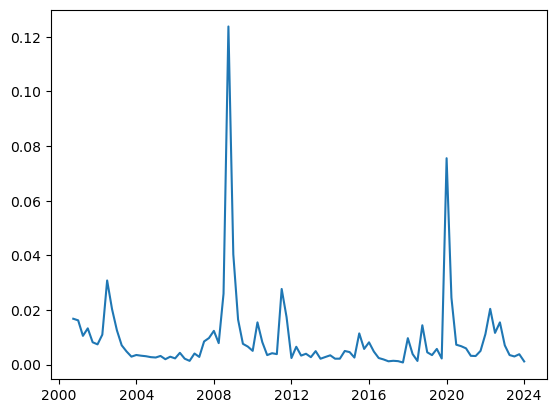

In [30]:
plt.plot(sp500_rv["Quarter_Date_Time"], sp500_rv["sp500_volatility"])

In [31]:
adfuller(sp500_rv["sp500_volatility"])

(-6.496507048771891,
 1.1906347251740378e-08,
 0,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 -443.2915706467295)

In [78]:
merged_df = (sp500_rv
 .merge(realized_volatility, on=["Quarter_Date_Time"])
 .merge(avg_q_une_texas, on=["Quarter_Date_Time"])
 .merge(merged_empl_texas, on=["Quarter_Date_Time"])
 .merge(labor_force_q_avg, on=["Quarter_Date_Time"])
)

merged_df = merged_df[(merged_df["Quarter_Date_Time"] < "2020")]
#merged_df["pandemic"] = ((merged_df["Quarter_Date_Time"] >=  "2020") & (merged_df["Quarter_Date_Time"] < "2022")).astype(int)

In [79]:
merged_df

,Quarter_Date_Time,sp500_volatility,sp_return,sp500_volatility_lag_1,sp500_volatility_lag_2,sp500_volatility_lag_3,sp500_volatility_lag_4,oil_price_realized_volatility,squared_log_diff_1,squared_log_diff_2,...,ur_lag_2,ur_lag_3,DATE,og_employees,service_employees,ratio,ratio_diff,Year,labor force,labor_force_pct_change
0,2000-10-01,0.016794,-0.090578,0.005754,0.016193,0.018307,0.002263,0.063454,0.049621,0.051347,...,4.466667,4.666667,2000-10-01,147.458274,7751.933333,0.019022,0.000336,2000,1.042038e+07,0.004479
1,2001-01-01,0.016205,-0.117107,0.016794,0.005754,0.016193,0.018307,0.030546,0.063454,0.049621,...,4.266667,4.466667,2001-01-01,149.930739,7781.366667,0.019268,0.000246,2001,1.047784e+07,0.005515
2,2001-04-01,0.010532,0.049406,0.016205,0.016794,0.005754,0.016193,0.034484,0.030546,0.063454,...,4.133333,4.266667,2001-04-01,154.539474,7794.733333,0.019826,0.000558,2001,1.051208e+07,0.003267
3,2001-07-01,0.013277,-0.160314,0.010532,0.016205,0.016794,0.005754,0.070618,0.034484,0.030546,...,4.200000,4.133333,2001-07-01,156.450575,7787.333333,0.020090,0.000264,2001,1.055470e+07,0.004054
4,2001-10-01,0.008185,0.090214,0.013277,0.010532,0.016205,0.016794,0.067888,0.070618,0.034484,...,4.633333,4.200000,2001-10-01,154.910565,7750.033333,0.019988,-0.000102,2001,1.060338e+07,0.004613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,2018-10-01,0.014402,-0.151220,0.001344,0.003866,0.009683,0.000785,0.038760,0.019447,0.024147,...,3.933333,4.033333,2018-10-01,253.782927,10732.800000,0.023646,0.000362,2018,1.377000e+07,0.002698
73,2019-01-01,0.004519,0.122467,0.014402,0.001344,0.003866,0.009683,0.017303,0.038760,0.019447,...,3.833333,3.933333,2019-01-01,253.313153,10787.900000,0.023481,-0.000164,2019,1.381549e+07,0.003304
74,2019-04-01,0.003483,0.036565,0.004519,0.014402,0.001344,0.003866,0.025113,0.017303,0.038760,...,3.800000,3.833333,2019-04-01,251.950806,10851.233333,0.023219,-0.000263,2019,1.387242e+07,0.004121
75,2019-07-01,0.005743,0.012785,0.003483,0.004519,0.014402,0.001344,0.058572,0.025113,0.017303,...,3.666667,3.800000,2019-07-01,246.759775,10919.566667,0.022598,-0.000621,2019,1.397329e+07,0.007271


In [80]:
model = VAR(merged_df[["ratio_diff", "oil_price_realized_volatility"]], merged_df[["sp500_volatility", "sp500_volatility_lag_1", "labor_force_pct_change"]])

In [81]:
results = model.fit(maxlags=4, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 08, Apr, 2024
Time:                     10:12:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -23.1483
Nobs:                     75.0000    HQIC:                  -23.4453
Log likelihood:           689.759    FPE:                5.40541e-11
AIC:                     -23.6427    Det(Omega_mle):     4.41362e-11
--------------------------------------------------------------------
Results for equation ratio_diff
                                      coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------
const                                   -0.000002         0.000102           -0.021           0.983
sp500_volatility                         0.003506         0.003172            1

In [36]:
results.test_causality("ratio_diff", ["oil_price_realized_volatility"]).summary()

Test statistic,Critical value,p-value,df
6.476,3.064,0.002,"(2, 134)"


In [83]:
results.is_stable()

True

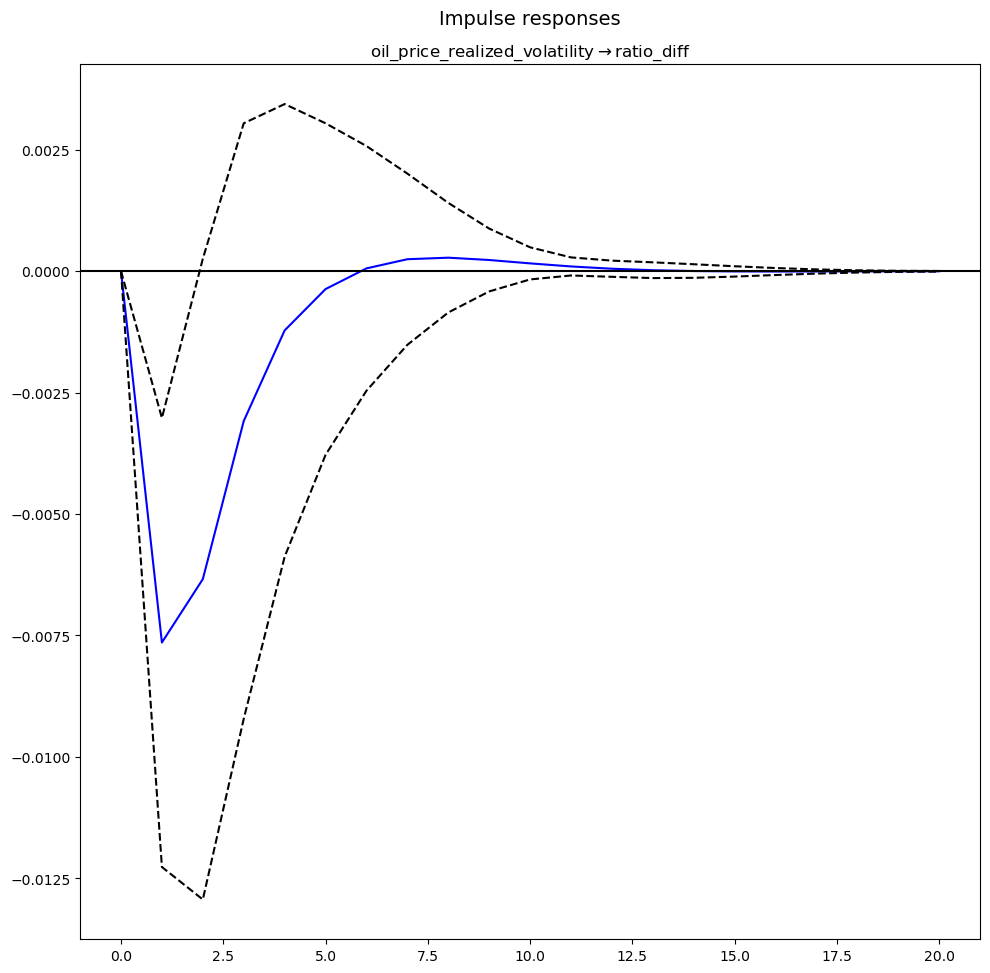

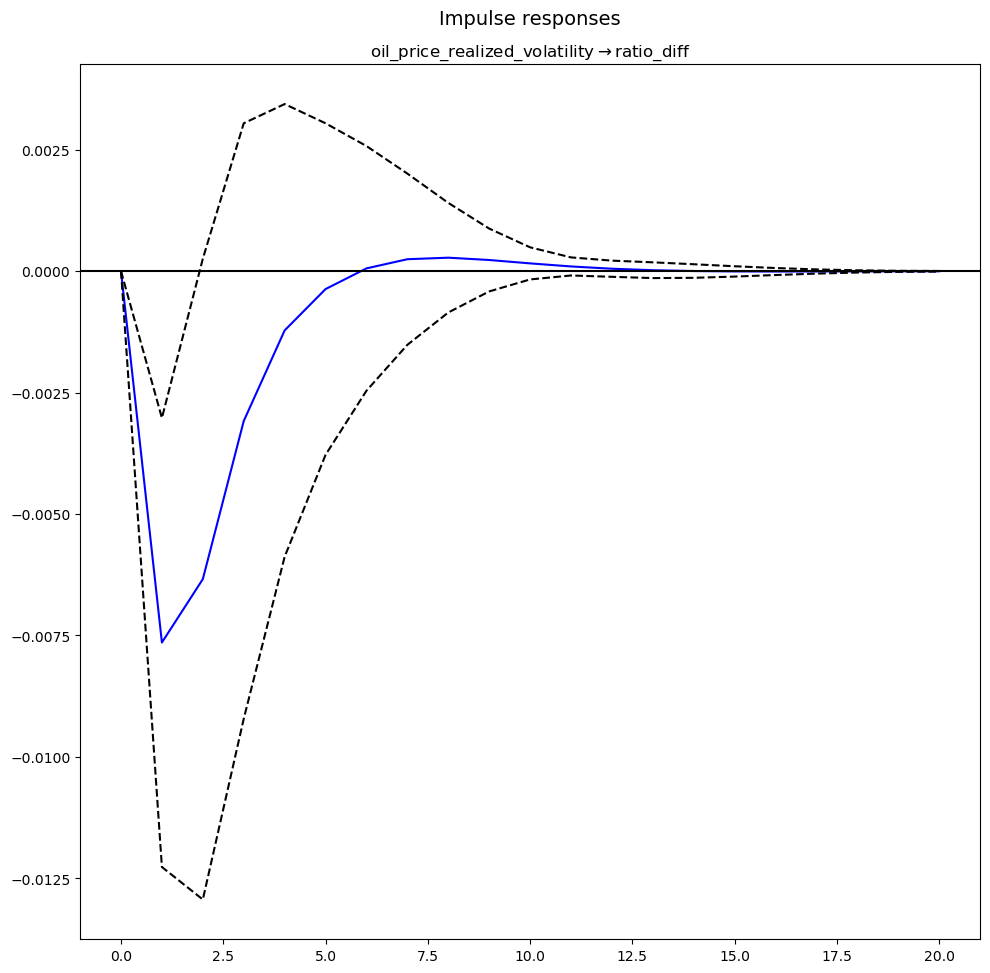

In [37]:
results.irf(periods=20).plot(response="ratio_diff", impulse="oil_price_realized_volatility")

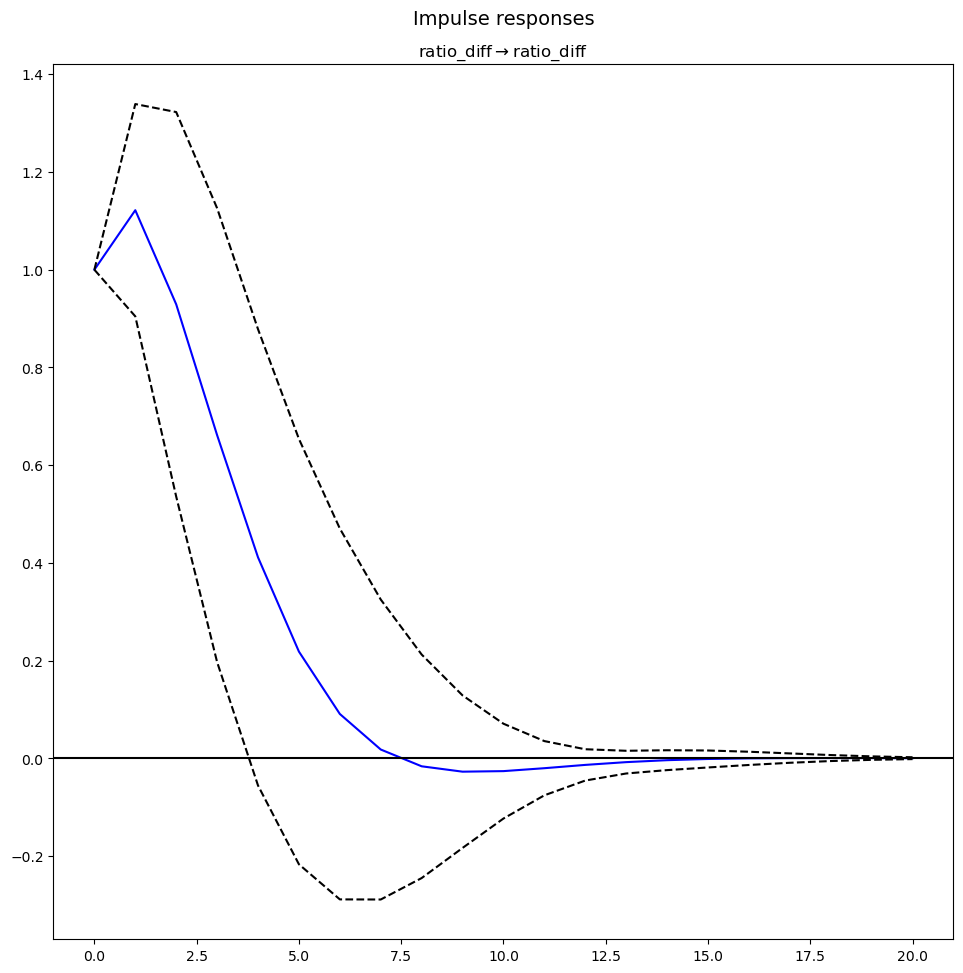

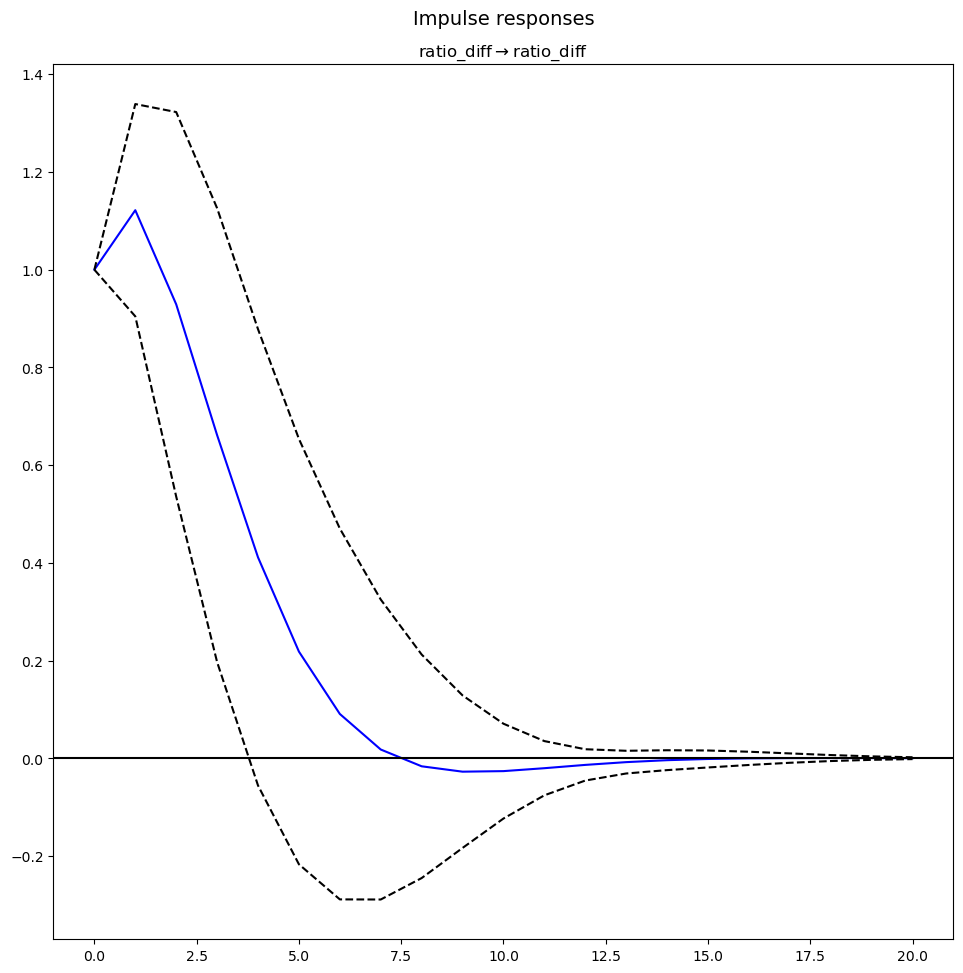

In [69]:
results.irf(periods=20).plot(response="ratio_diff", impulse="ratio_diff")

In [38]:
grangercausalitytests(merged_df[["ratio_diff", "oil_price_realized_volatility"]], maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=27.4793 , p=0.0000  , df_denom=73, df_num=1
ssr based chi2 test:   chi2=28.6086 , p=0.0000  , df=1
likelihood ratio test: chi2=24.2814 , p=0.0000  , df=1
parameter F test:         F=27.4793 , p=0.0000  , df_denom=73, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=14.5100 , p=0.0000  , df_denom=70, df_num=2
ssr based chi2 test:   chi2=31.0928 , p=0.0000  , df=2
likelihood ratio test: chi2=26.0119 , p=0.0000  , df=2
parameter F test:         F=14.5100 , p=0.0000  , df_denom=70, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.1472  , p=0.0000  , df_denom=67, df_num=3
ssr based chi2 test:   chi2=30.3087 , p=0.0000  , df=3
likelihood ratio test: chi2=25.4034 , p=0.0000  , df=3
parameter F test:         F=9.1472  , p=0.0000  , df_denom=67, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.7838  , p=0.0000  , df_d

{1: ({'ssr_ftest': (27.47934058946944, 1.484456112622993e-06, 73.0, 1),
   'ssr_chi2test': (28.60862855889969, 8.858655723110978e-08, 1),
   'lrtest': (24.28144511983237, 8.323703191870919e-07, 1),
   'params_ftest': (27.479340589469448, 1.484456112622993e-06, 73.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (14.509958026301407, 5.347391941184077e-06, 70.0, 2),
   'ssr_chi2test': (31.092767199217302, 1.771297008406582e-07, 2),
   'lrtest': (26.011932007598944, 2.2468844194534383e-06, 2),
   'params_ftest': (14.509958026303906, 5.347391941174613e-06, 70.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (9.14721756783458, 3.728858626729576e-05, 67.0, 3),
   'ssr_chi2test': (30.308691045660847, 1.1883764755240625e-06, 3),
   'lrtest': (25.403429860563847, 1.2714115872628431e-05, 3),
   'params_ftest': (9.147217567835956, 3.7288586267242834e-05, 67.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 